In [ ]:
# --- Celda 1: Instalación ---
!pip install opencv-python-headless matplotlib numpy tqdm

In [ ]:
# --- Celda 2: Importaciones y Datos Simulados ---
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

# --- Simulación de Datos de RescueNet ---
# Vamos a crear una máscara de 400x400 píxeles.
# En RescueNet, cada clase es un valor de píxel (o un color).
# Asumamos que la leyenda de RescueNet dice:
# 0 = Fondo
# 6 = Road-Clear (Carretera despejada)
# 7 = Road-Blocked (Carretera bloqueada)
# 8 = Vehicle (Vehículo)

print("Creando máscara de segmentación semántica simulada...")
# Crear un lienzo negro (0 = Fondo)
mask_semantica = np.zeros((400, 400), dtype=np.uint8)

# Dibujar una "Carretera Despejada" (clase 6)
cv2.rectangle(mask_semantica, (50, 0), (350, 400), 6, -1)

# Dibujar un "Vehículo" (clase 8) en la carretera
cv2.rectangle(mask_semantica, (70, 70), (170, 150), 8, -1)

# Dibujar "Escombros" (clase 7) en la carretera
cv2.rectangle(mask_semantica, (200, 250), (300, 350), 7, -1)

# Simular la imagen original (solo para contexto)
imagen_original = np.ones((400, 400, 3), dtype=np.uint8) * 200 # Lienzo gris claro
print("Datos simulados listos.")

Creando máscara de segmentación semántica simulada...
Datos simulados listos.


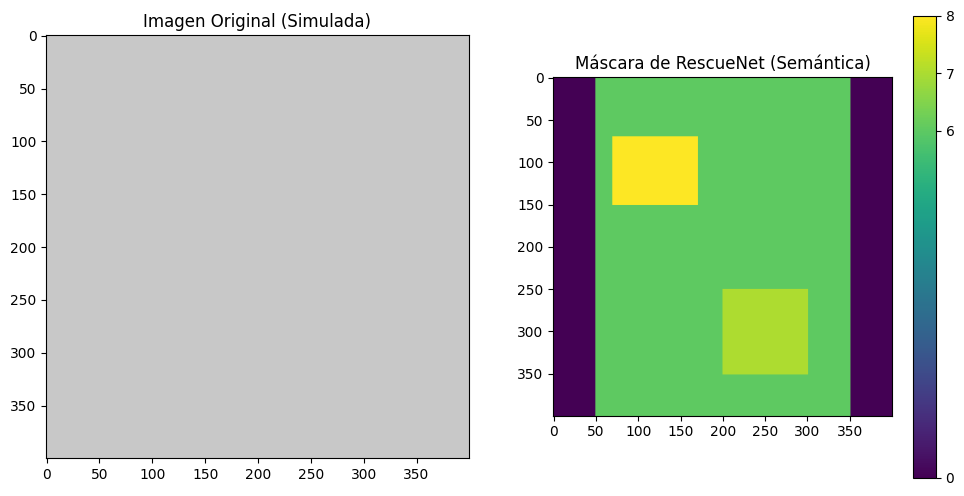

Como puedes ver, la máscara es UNA imagen donde cada 'color' (valor) es una clase.


In [ ]:
# --- Celda 3: Visualización de la Máscara Semántica ---
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Imagen Original (Simulada)")
plt.imshow(imagen_original)

plt.subplot(1, 2, 2)
plt.title("Máscara de RescueNet (Semántica)")
# Usamos 'viridis' para ver los diferentes valores de clase
plt.imshow(mask_semantica, cmap='viridis')
plt.colorbar(ticks=[0, 6, 7, 8])

plt.show()

print("Como puedes ver, la máscara es UNA imagen donde cada 'color' (valor) es una clase.")

In [ ]:
# --- Celda 4: Lógica de Conversión (El "Script Mágico") ---

# 1. Definimos nuestro "mapeo de clases" del TFG
# Queremos fusionar las clases de RescueNet en las nuestras.
# Nuestra Clase 0 = "OBSTACULO"
# Nuestra Clase 1 = "ZONA_VIABLE"

# Clases de RescueNet que son "OBSTACULO"
clases_obstaculo = [7, 8] # Road-Blocked, Vehicle

# Clases de RescueNet que son "ZONA_VIABLE"
clases_zona_viable = [6] # Road-Clear

# Lista final para el bucle
# Formato: (Nombre de nuestra clase, ID de nuestra clase, lista de IDs de RescueNet)
clases_a_extraer = [
    ("OBSTACULO", 0, clases_obstaculo),
    ("ZONA_VIABLE", 1, clases_zona_viable)
]

# Obtenemos las dimensiones de la imagen para normalizar (YOLO lo necesita)
h, w = mask_semantica.shape
yolo_lines = [] # Aquí guardaremos las líneas para el archivo .txt

print(f"Iniciando conversión a formato YOLO (polígono)...")
print(f"Dimensiones de la imagen: Ancho={w}, Alto={h}")

# 2. Bucle principal: Extraer polígonos para cada una de nuestras clases
for nombre_clase, id_clase_yolo, ids_rescuenet in clases_a_extraer:

    print(f"\nProcesando Clase: '{nombre_clase}' (ID: {id_clase_yolo})")

    # 3. Creamos una máscara binaria temporal SOLO para esta clase
    # (Ej: "dame todos los píxeles que sean 7 o 8")
    mask_temporal = np.isin(mask_semantica, ids_rescuenet).astype(np.uint8)

    # 4. Usamos OpenCV para encontrar los contornos (siluetas)
    # cv2.findContours es la función clave aquí
    contours, _ = cv2.findContours(mask_temporal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    print(f"Se encontraron {len(contours)} instancias (objetos) para esta clase.")

    # 5. Convertimos cada contorno (polígono) a formato YOLO
    for contour in contours:
        # Un polígono puede ser demasiado complejo, lo simplificamos un poco
        # (Esto es opcional pero recomendado)
        if contour.shape[0] < 3: # Ignorar líneas o puntos
            continue

        # El contorno es una lista de puntos [x, y].
        # Lo normalizamos (dividimos por ancho y alto) para que esté entre 0 y 1
        segment = contour.flatten().astype(float)

        # Normalización: x se divide por 'w', y se divide por 'h'
        segment[0::2] /= w  # Coordenadas X
        segment[1::2] /= h  # Coordenadas Y

        # Lo convertimos a una string (cadena de texto)
        yolo_segment = " ".join(segment.astype(str))

        # Creamos la línea final para el archivo .txt
        # Formato: <id_clase> <x1> <y1> <x2> <y2> ...
        yolo_line = f"{id_clase_yolo} {yolo_segment}"
        yolo_lines.append(yolo_line)

print("\n--- CONVERSIÓN COMPLETADA ---")
print("Líneas generadas para el archivo YOLO .txt:")
for line in yolo_lines:
    print(line)

Iniciando conversión a formato YOLO (polígono)...
Dimensiones de la imagen: Ancho=400, Alto=400

Procesando Clase: 'OBSTACULO' (ID: 0)
Se encontraron 2 instancias (objetos) para esta clase.

Procesando Clase: 'ZONA_VIABLE' (ID: 1)
Se encontraron 1 instancias (objetos) para esta clase.

--- CONVERSIÓN COMPLETADA ---
Líneas generadas para el archivo YOLO .txt:
0 0.5 0.625 0.5 0.875 0.75 0.875 0.75 0.625
0 0.175 0.175 0.175 0.375 0.425 0.375 0.425 0.175
1 0.125 0.0 0.125 0.9975 0.875 0.9975 0.875 0.0


In [ ]:
# --- Celda 5: Guardar el Archivo .txt ---

# Creamos las carpetas de salida simuladas
Path("dataset_yolo/labels/train").mkdir(parents=True, exist_ok=True)
output_path = "dataset_yolo/labels/train/imagen_simulada.txt"

with open(output_path, 'w') as f:
    f.write("\n".join(yolo_lines))

print(f"¡Archivo de anotación YOLO guardado exitosamente en: {output_path}!")

# Comprobamos el contenido del archivo
print("\nContenido del archivo:")
with open(output_path, 'r') as f:
    print(f.read())

¡Archivo de anotación YOLO guardado exitosamente en: dataset_yolo/labels/train/imagen_simulada.txt!

Contenido del archivo:
0 0.5 0.625 0.5 0.875 0.75 0.875 0.75 0.625
0 0.175 0.175 0.175 0.375 0.425 0.375 0.425 0.175
1 0.125 0.0 0.125 0.9975 0.875 0.9975 0.875 0.0
